# DataBase - Monthly beer production
link:> https://www.kaggle.com/datasets/shenba/time-series-datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from xgboost import XGBRegressor

In [2]:
data_f = pd.read_csv('data\monthly-beer-production-in-austr.csv', index_col='Month', parse_dates=True)
data_f.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [5]:
data_f.rename(columns={'Monthly beer production': 'PMC'}, inplace=True)
data_f.head()

,PMC
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


PMC => Produção mensal de cerveja

In [6]:
data_f.describe()

,PMC
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [7]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PMC     476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [8]:
data_f.tail()

,PMC
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


In [9]:
data_f.isnull().sum()

PMC    0
dtype: int64

Text(0.5, 1.0, 'Produção mensal de cerveja')

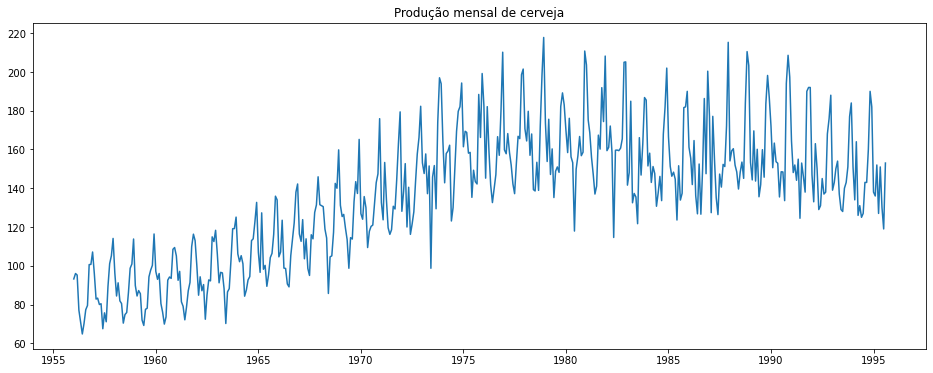

In [10]:
plt.figure(figsize=(16,6))
plt.plot(data_f)
plt.title('Produção mensal de cerveja')

In [11]:
data_f['PMC'].max()

217.8

In [17]:
data_f.loc[data_f['PMC'] == 217.8]

,PMC
Month,
1978-12-01,217.8


# Usando ARIMA

<Figure size 432x288 with 0 Axes>

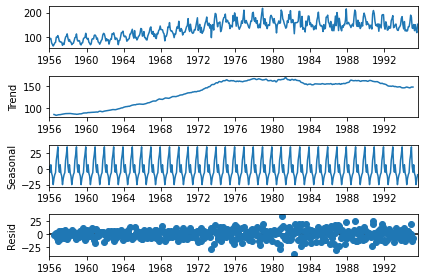

In [22]:
# Criando Gráfico de Tendencia, Sazonalidade e residuos

plot_tsr = seasonal_decompose(data_f)
fig = plt.figure()
fig = plot_tsr.plot()

c:\Users\junio\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


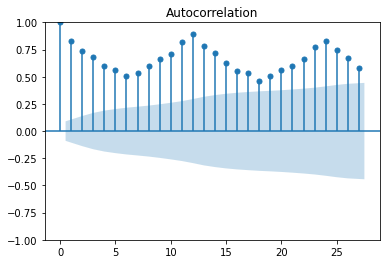

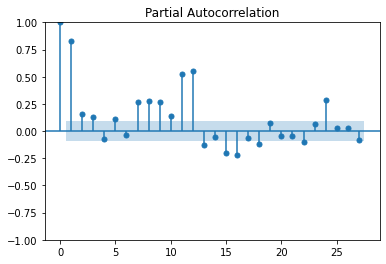

In [23]:
# Gráfico de pirulito (do inglês lollipop chart) 
# nos mostra a quantidade de termos que precisaremos informar de PDQ(ARIMA)
plot_acf(data_f)
plot_pacf(data_f)
plt.show()

In [25]:
# Teste de estacionalidade. Se der acima de 0,05 quer dizer que não é estacionaria

result2 = adfuller(data_f['PMC'].diff().dropna())
print(f'Teste ADF: {result2[0]}')
print(f'p-valor: {result2[1]}')

Teste ADF: -4.980663743064756
p-valor: 2.423411785996464e-05


In [26]:
# treinar o ARIMA para escolher o melhor modelo

fit_arima = auto_arima(data_f, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
seasonal=True,
m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2,
information_criterion='aic',
trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=3667.083, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=4549.066, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=3909.258, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=3687.775, Time=0.52 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=3536.571, Time=1.04 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=3958.026, Time=0.88 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=3521.626, Time=1.32 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(2,1,2)[6]             : AIC=inf, Time=1.08 sec
 ARIMA(2,1,1)(2,1,2)[6]             : AIC=3509.218, Time=1.43 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=3518.879, Time=1.42 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=inf, Time=1.41 s

In [27]:
# treinando o modelo do SARIMAX com os valores (2,1,2)(1,1,2)[6], obtidos com o uso do auto_arima.
model = SARIMAX(data_f, order=(2,1,1), seasonal_order=(2,1,2,6))
result_sarimax = model.fit()

c:\Users\junio\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\junio\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\junio\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    PMC   No. Observations:                  476
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 6)   Log Likelihood               -1746.609
Date:                                Sun, 22 May 2022   AIC                           3509.218
Time:                                        18:03:53   BIC                           3542.423
Sample:                                    01-01-1956   HQIC                          3522.283
                                         - 08-01-1995                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1806      0.040     -4.487      0.000      -0.260      -0.102
ar.L2         -0.1905      0.043     -4.407      0.000      -0.275      -0.106
ma.L1         -0.8659      0.026    -33.802      0.000      -0.916      -0.816
ar.S.L6       -0.7941      0.053    -15.038      0.000      -0.898      -0.691
ar.S.L12       0.2044      0.052      3.901      0.000       0.102       0.307
ma.S.L6       -0.0506      0.037     -1.351      0.177      -0.124       0.023
ma.S.L12      -0.8265      0.030    -27.707      0.000      -0.885      -0.768
sigma2        93.6430      4.990     18.766      0.000      83.863     103.423
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.66
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Criar predições com base no modelo criado
# Predições para 12 meses atrás

ant_predict = result_sarimax.get_prediction(start=-12)
predict_mean = ant_predict.predicted_mean

In [30]:
predict_mean

1994-09-01    136.675753
1994-10-01    158.847238
1994-11-01    174.904094
1994-12-01    184.359064
1995-01-01    145.250666
1995-02-01    139.732832
1995-03-01    155.854023
1995-04-01    137.478422
1995-05-01    134.989171
1995-06-01    121.399967
1995-07-01    128.274788
1995-08-01    138.637916
Freq: MS, Name: predicted_mean, dtype: float64

In [31]:
data_f.tail(12)

,PMC
Month,
1994-09-01,143.0
1994-10-01,160.0
1994-11-01,190.0
1994-12-01,182.0
1995-01-01,138.0
1995-02-01,136.0
1995-03-01,152.0
1995-04-01,127.0
1995-05-01,151.0


In [32]:
# Intervalo de confiança

interval_confi = ant_predict.conf_int()
limit_up = interval_confi.iloc[:,0]
limit_down = interval_confi.iloc[:,1]

print(limit_up[0], limit_down[0])
print(predict_mean[0])

117.70927565208879 155.6422307364629
136.67575319427584


In [33]:
# Pegando as datas previstas e totais
date_predict = np.asanyarray(predict_mean.index)
date_all = np.asanyarray(data_f.index)

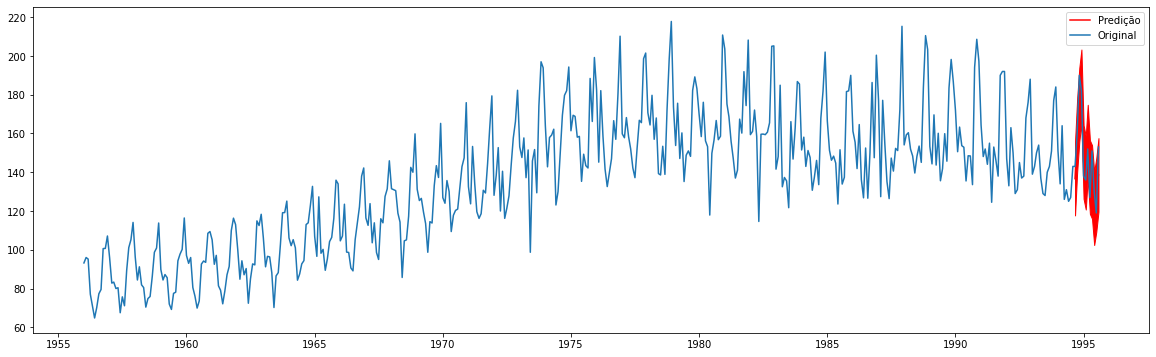

In [35]:
# Criar gráfico com as predições de 12 dias para tras
plt.figure(figsize=(20,6))
plt.plot(date_predict,predict_mean.values, color='r', label= 'Predição')
plt.fill_between(date_predict, limit_down, limit_up, color='r')
plt.plot(date_all, data_f.values, label='Original')
plt.legend()
plt.show()

In [36]:
# Calcular erro médio quadratico
emq_sarimax = sqrt(mean_squared_error(data_f[-12:].values, predict_mean.values))
print(emq_sarimax)

9.524231827813898


# Forecast com ARIMA

In [37]:
# Criar predições com base no modelo criado
# Predições para 12 

forescast = result_sarimax.get_forecast(steps=12)
forescast_mean = forescast.predicted_mean
forescast_mean.size

12

In [38]:
# Pegando intervalo de confiança
forescast_confi = forescast.conf_int()
forescast_down = forescast_confi.iloc[:,0]
forescast_up = forescast_confi.iloc[:,1]

print(forescast_down[0], forescast_up[0])
print(forescast_mean[0])

117.95923844635539 155.8921755952957
136.92570702082554


In [39]:
# Pegar as datas de predição(Forecast)

date_forecast = np.asarray(forescast_mean.index)

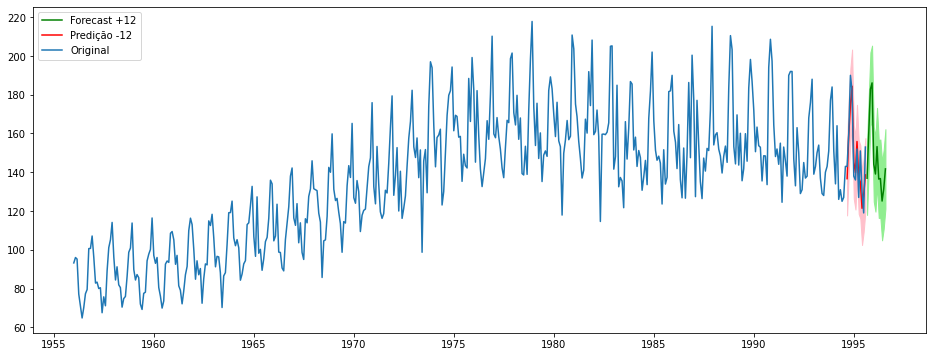

In [43]:
# Criar Gráfico com os dados de Forecast

plt.figure(figsize=(16,6))
plt.plot(date_forecast, forescast_mean.values, color='g', label='Forecast +12')
plt.fill_between(date_forecast,forescast_down, forescast_up, color='lightgreen')

plt.plot(date_predict, predict_mean.values, color='r', label='Predição -12')
plt.fill_between(date_predict,limit_down, limit_up, color='pink')

plt.plot(date_all, data_f.values,label='Original')
plt.legend(loc='upper left')
plt.show()

# OBSERVAÇÕES:
- O modelo consegue uma precisão proxima de 88%.
- Pode ser escalado para mais meses(mais com previsão com porcentagem de acerto cada vez mais baixa).

# Prevendo com ML XGBoost

In [44]:
# Data frame
data_f

,PMC
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


In [45]:
data_f.tail(23)

,PMC
Month,
1993-10-01,151.0
1993-11-01,177.0
1993-12-01,184.0
1994-01-01,151.0
1994-02-01,134.0
1994-03-01,164.0
1994-04-01,126.0
1994-05-01,131.0
1994-06-01,125.0


In [46]:
# Distribuindo valores da base de dados para Treino e teste de validação
treino = data_f.loc[data_f.index <= '1993-10-01']
validacao = data_f.loc[data_f.index > '1993-10-01']

treino.shape, validacao.shape

((454, 1), (22, 1))

In [47]:
treino.head()

,PMC
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [48]:
validacao.head()

,PMC
Month,
1993-11-01,177.0
1993-12-01,184.0
1994-01-01,151.0
1994-02-01,134.0
1994-03-01,164.0


In [50]:
# Criando classe com valores 1 caso no futuro
treino['targ'] = treino['PMC'].shift(-1)
validacao['targ'] = validacao['PMC'].shift(-1)

C:\Users\junio\AppData\Local\Temp\ipykernel_17188\2609497493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['targ'] = treino['PMC'].shift(-1)
C:\Users\junio\AppData\Local\Temp\ipykernel_17188\2609497493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['targ'] = validacao['PMC'].shift(-1)


In [51]:
treino.tail()

,PMC,targ
Month,,
1993-06-01,129.0,128.0
1993-07-01,128.0,140.0
1993-08-01,140.0,143.0
1993-09-01,143.0,151.0
1993-10-01,151.0,NaN


In [52]:
validacao.tail()

,PMC,targ
Month,,
1995-04-01,127.0,151.0
1995-05-01,151.0,130.0
1995-06-01,130.0,119.0
1995-07-01,119.0,153.0
1995-08-01,153.0,NaN


In [53]:
# Dropa as linas com valores nulos (NaN)
treino.dropna(axis=0, inplace=True)
validacao.dropna(axis=0, inplace=True)

C:\Users\junio\AppData\Local\Temp\ipykernel_17188\2530225539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino.dropna(axis=0, inplace=True)
C:\Users\junio\AppData\Local\Temp\ipykernel_17188\2530225539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao.dropna(axis=0, inplace=True)


In [55]:
# separa x e y de treino e teste

X_train = treino.loc[:, ['PMC']].values
Y_train = treino.loc[:, ['targ']].values
X_test = validacao.loc[:,['PMC']].values
Y_test = validacao.loc[:,['targ']].values

# Comprimento dos dados:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((453, 1), (453, 1), (21, 1), (21, 1))

In [56]:
# Treinamento do modelo XGBoost

model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [57]:
validacao.iloc[0]

PMC     177.0
targ    184.0
Name: 1993-11-01 00:00:00, dtype: float64

In [58]:
predict_xgb = model_xgb.predict(X_test[0])
predict_xgb

array([154.39813], dtype=float32)

In [65]:
n = 154
corretor_cima = (n+(n*15/100))
corretor_baixo = (n-(n*15/100))

print(corretor_cima, corretor_baixo)

177.1 130.9
